In [1]:
# Machine Learning Library
import pandas as pd
import numpy as np
import pickle
import nltk
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import seaborn as sns
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, recall_score, precision_score
plt.style.use('ggplot')

In [2]:
# Deep Learning Library
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, LSTM, Dense, Dropout, SimpleRNN, GRU, Bidirectional, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.text import one_hot,Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [4]:
train_data = pd.read_csv("shuffled_data_file.txt", header = None, sep=";", names=["Sl_No","Comment", "Psy_Emotion","Categorical_Emotion"], encoding="utf-8")

In [5]:
train_data.drop(['Sl_No'], axis=1, inplace=True)

In [6]:
train_data.head()

Comment              Psy_Emotion  \
0        Treated myself to a movie night for Rs 500.        Emotional Comfort   
1  Invested Rs 3200 in cryptocurrency for potenti...  Experiential Investment   
2  Planned a fun-filled day trip with family, spe...            Social Outlay   
3                Invested Rs 7980 in cryptocurrency.  Experiential Investment   
4                     Invested Rs 5600 in a startup.  Experiential Investment   

  Categorical_Emotion  
0       Entertainment  
1  Financial Services  
2       Entertainment  
3  Financial Services  
4  Financial Services

In [7]:
train_data.shape

(1003, 3)

In [8]:
train_data.isnull().sum()

Comment                0
Psy_Emotion            0
Categorical_Emotion    0
dtype: int64

In [9]:
train_data.duplicated().sum()

127

In [10]:
train_data.drop_duplicates(inplace=True)

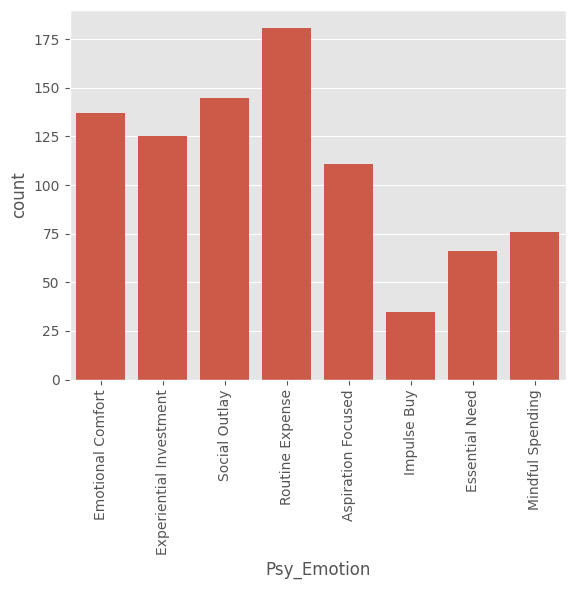

In [11]:
sns.countplot(x = train_data['Psy_Emotion'])
plt.xticks(rotation=90)
plt.show()

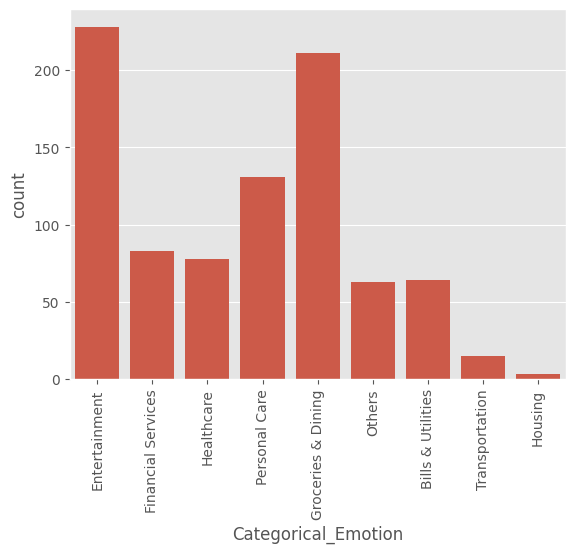

In [12]:
sns.countplot(x = train_data['Categorical_Emotion'])
plt.xticks(rotation=90)
plt.show()

In [13]:
train_data['Psy_Emotion'].value_counts()

Psy_Emotion
Routine Expense            181
Social Outlay              145
Emotional Comfort          137
Experiential Investment    125
Aspiration Focused         111
Mindful Spending            76
Essential Need              66
Impulse Buy                 35
Name: count, dtype: int64

In [14]:
train_data['Categorical_Emotion'].value_counts()

Categorical_Emotion
Entertainment         228
Groceries & Dining    211
Personal Care         131
Financial Services     83
Healthcare             78
Bills & Utilities      64
Others                 63
Transportation         15
Housing                 3
Name: count, dtype: int64

In [15]:
train_data['length'] = [len(x) for x in train_data['Comment']]

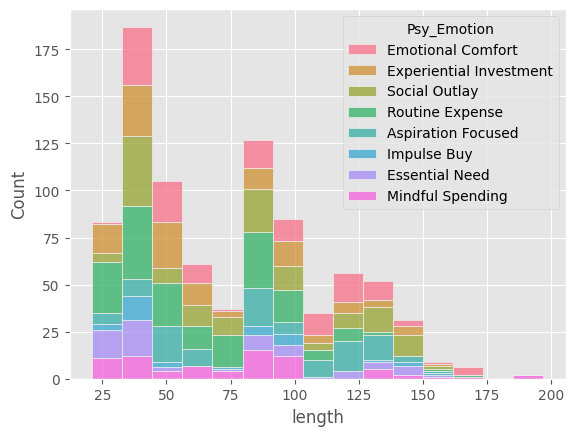

In [16]:
# data distribution
df2 = train_data.copy()
df2['length'] = [len(x) for x in df2['Comment']]

# Convert the 'length' column to a numpy array
length_values = df2['length'].values

# Use sns.histplot instead of sns.kdeplot for simplicity
sns.histplot(data=df2, x='length', hue='Psy_Emotion', multiple='stack')

plt.show()

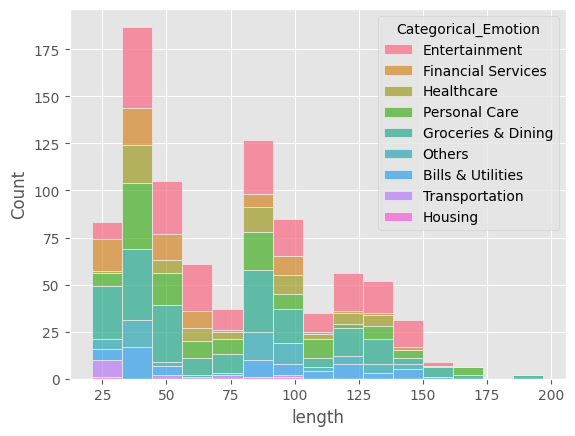

In [17]:
# Use sns.histplot instead of sns.kdeplot for simplicity
sns.histplot(data=df2, x='length', hue='Categorical_Emotion', multiple='stack')

plt.show()

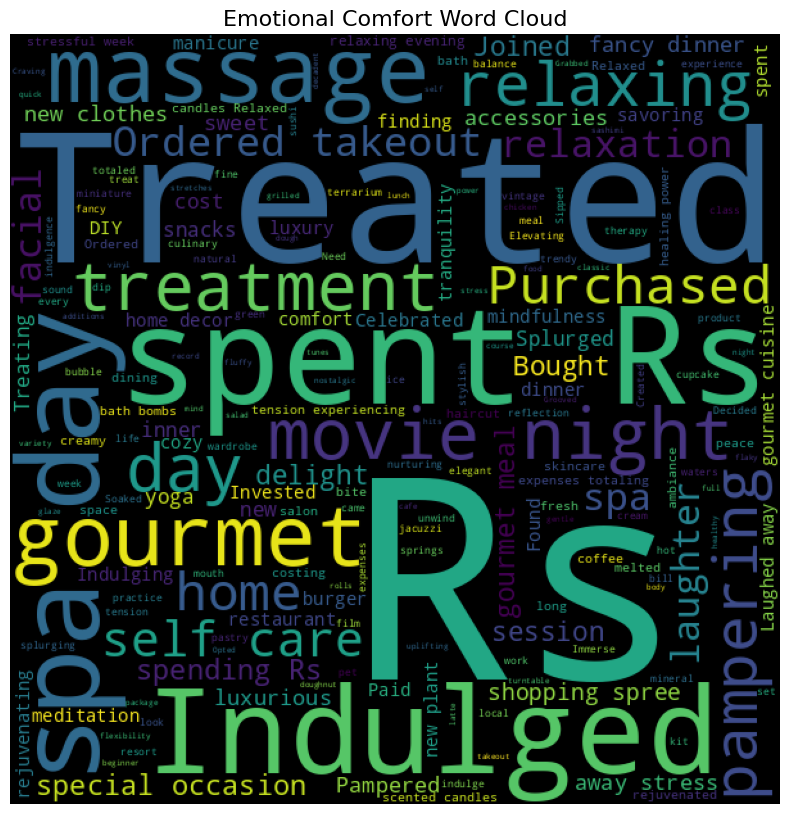

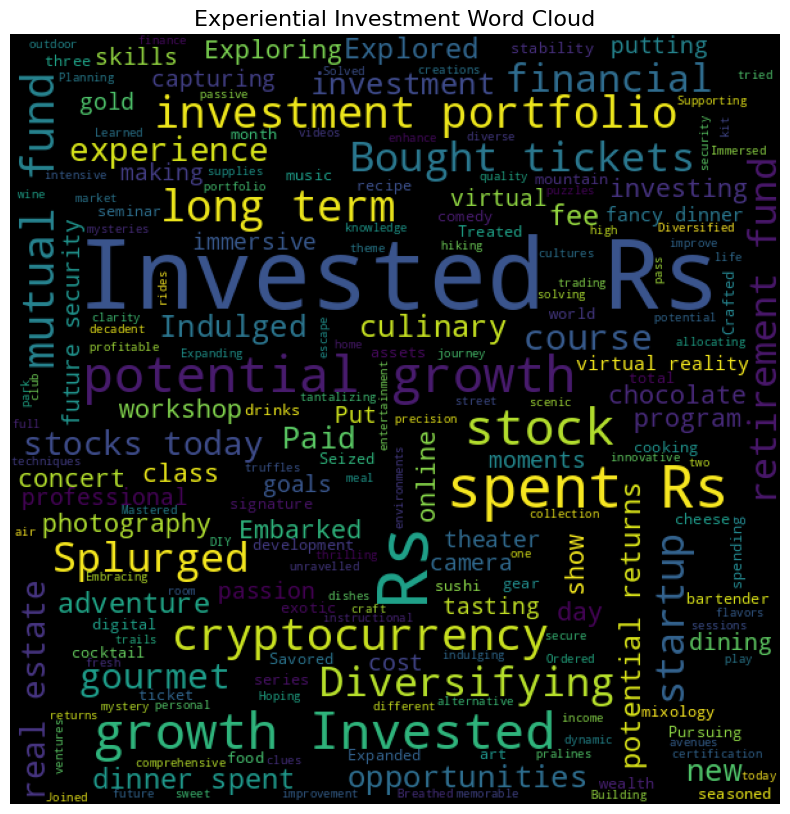

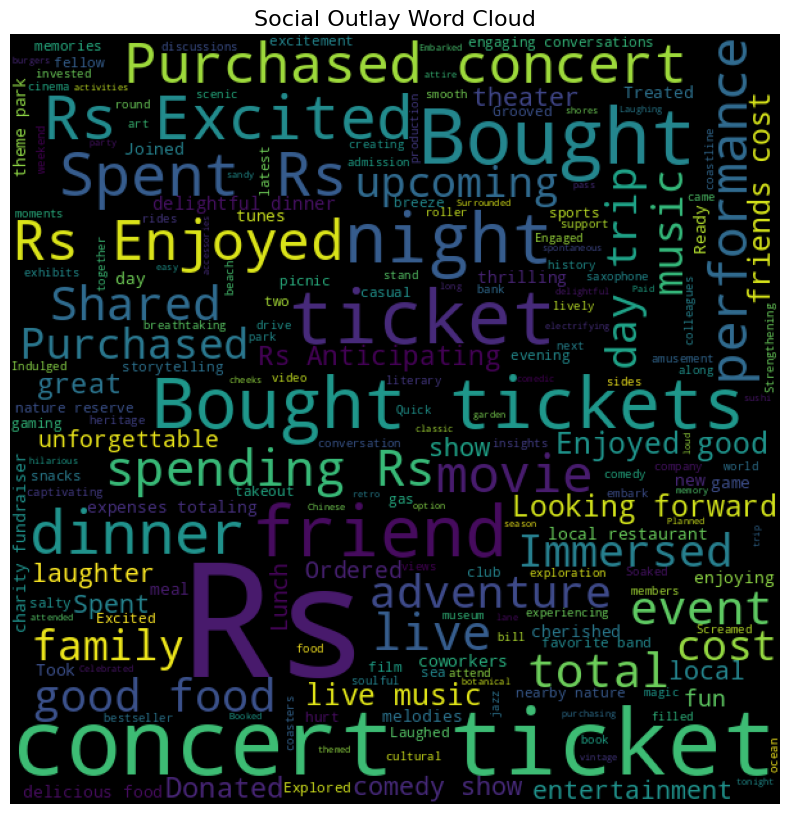

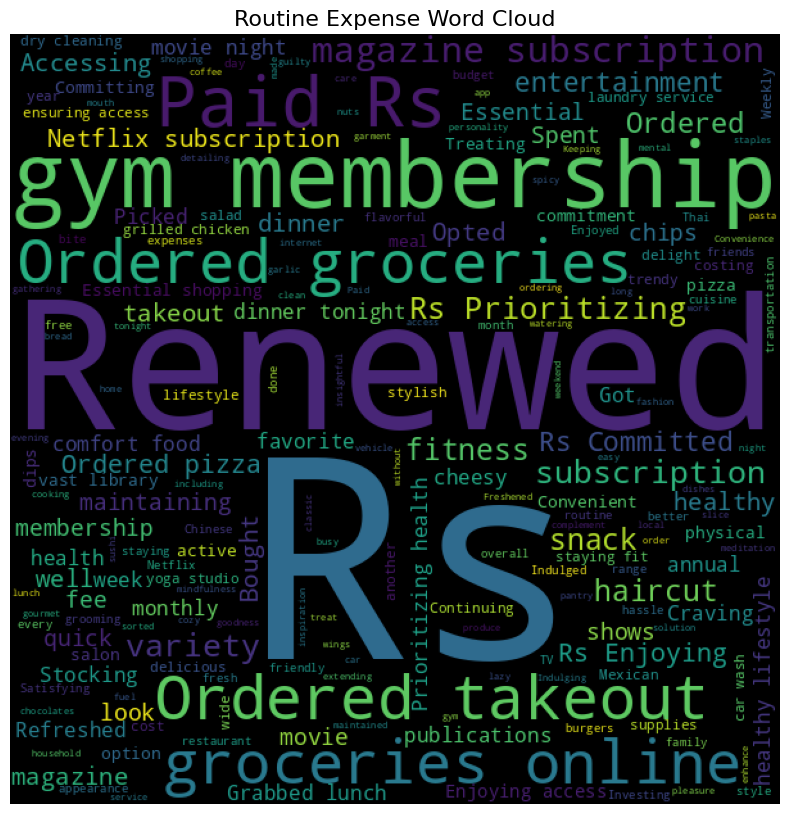

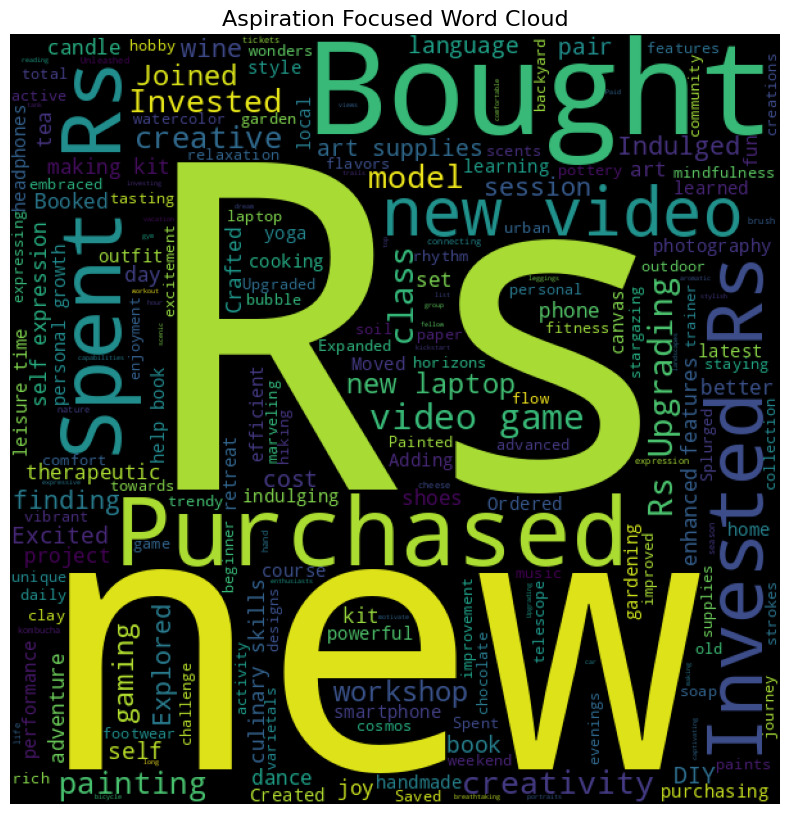

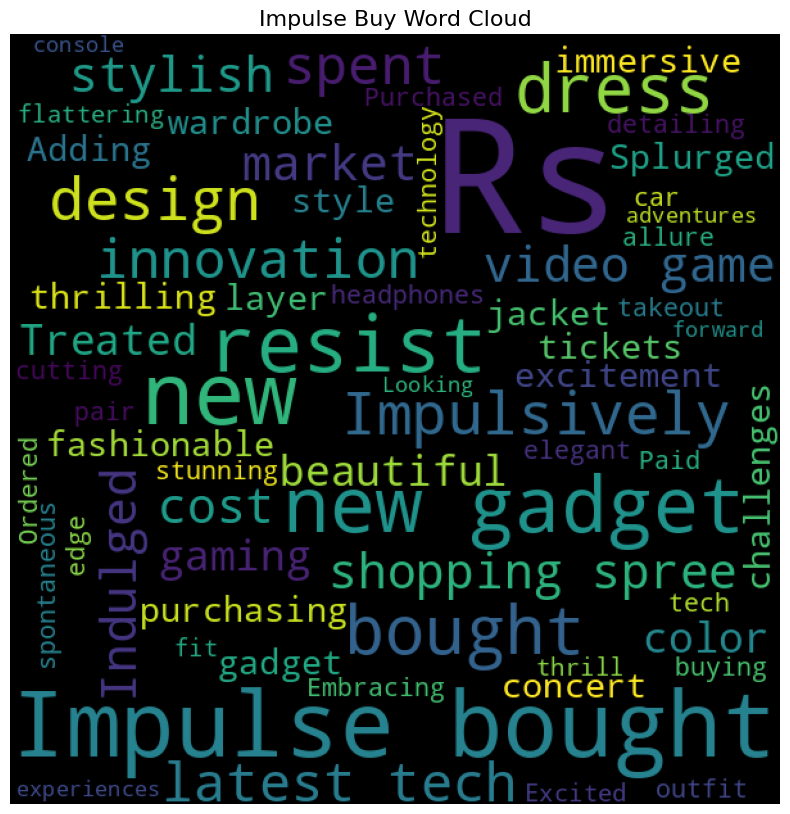

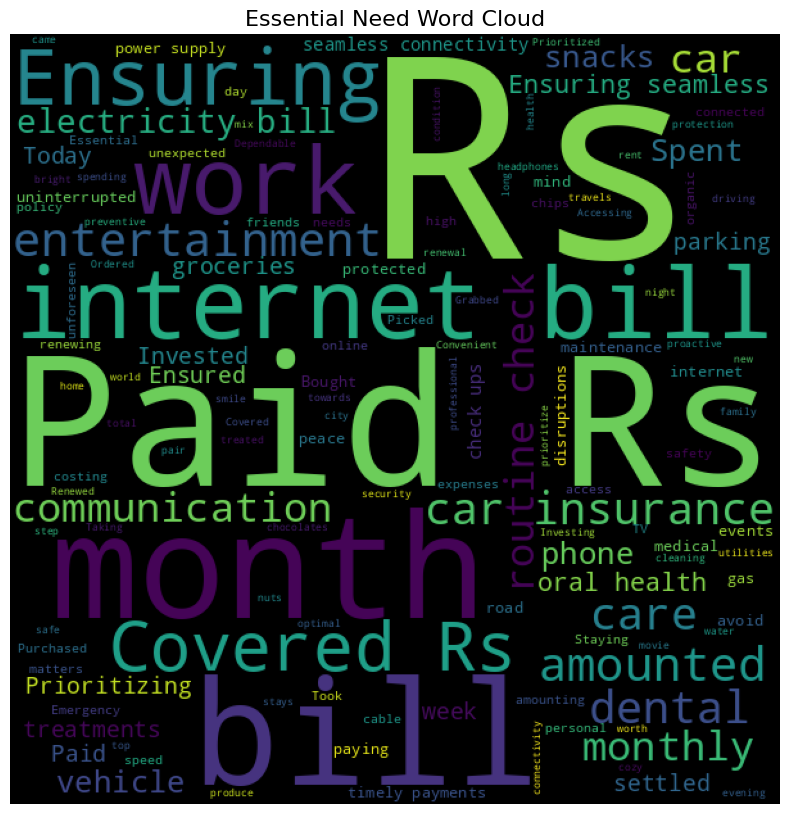

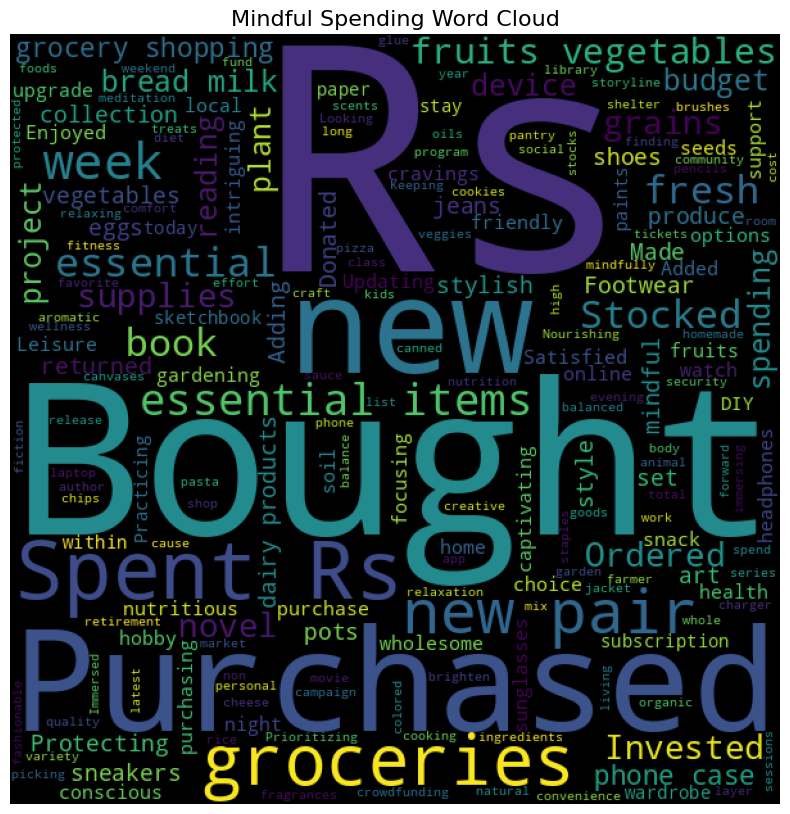

In [18]:
# Words cloud for each emotions
def words_cloud(wordcloud, df):
    plt.figure(figsize=(10, 10))
    plt.title(df+' Word Cloud', size = 16)
    plt.imshow(wordcloud)
    # No axis details
    plt.axis("off");
emotions_list = train_data['Psy_Emotion'].unique()
for emotion in emotions_list:
    text = ' '.join([sentence for sentence in train_data.loc[train_data['Psy_Emotion'] == emotion,'Comment']])
    wordcloud = WordCloud(width = 600, height = 600).generate(text)
    words_cloud(wordcloud, emotion)

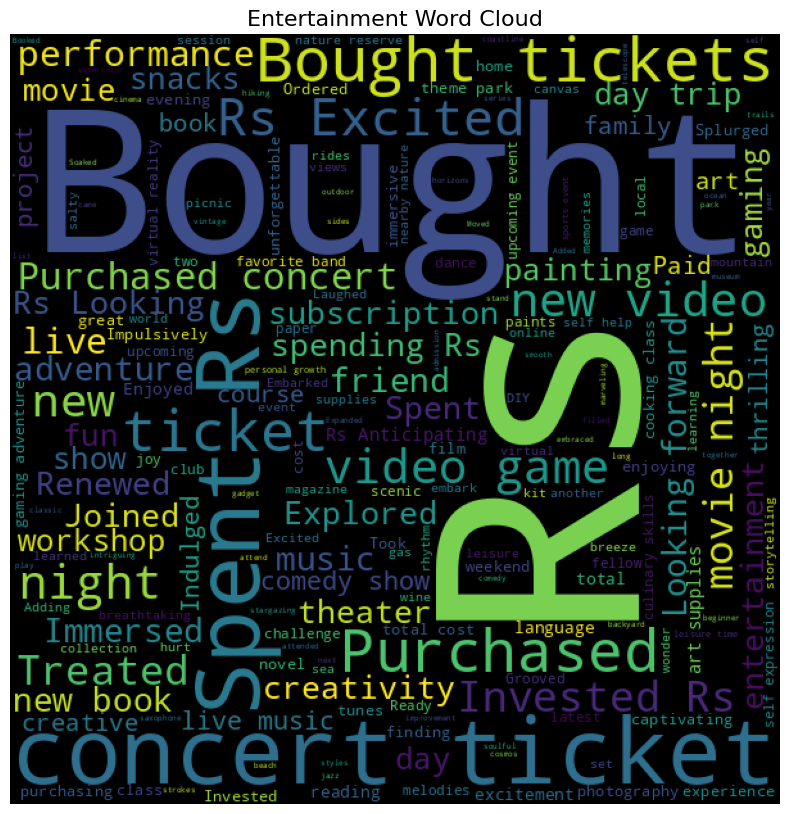

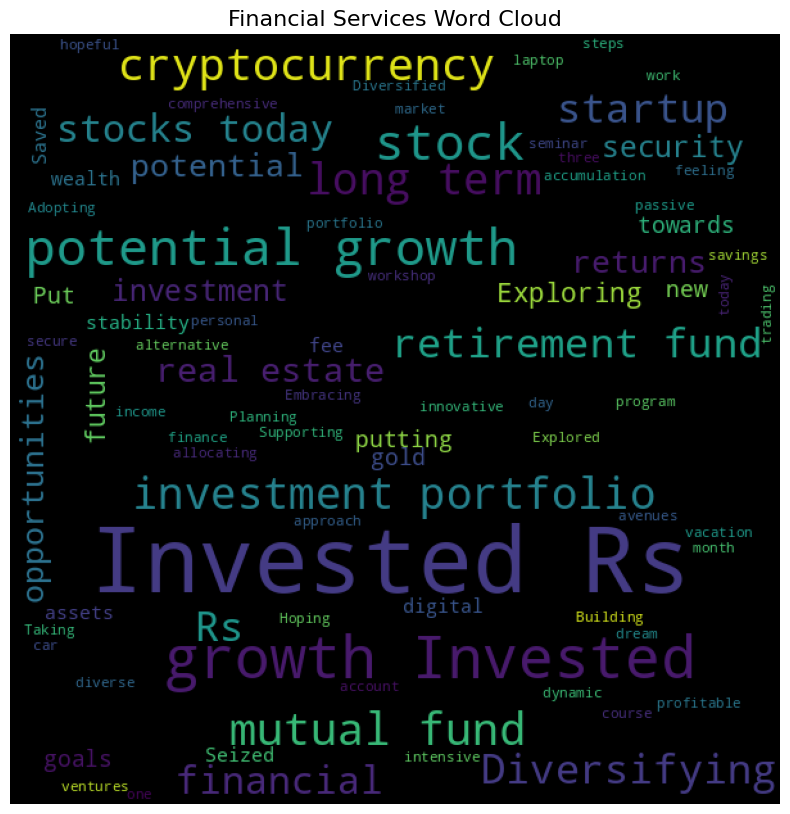

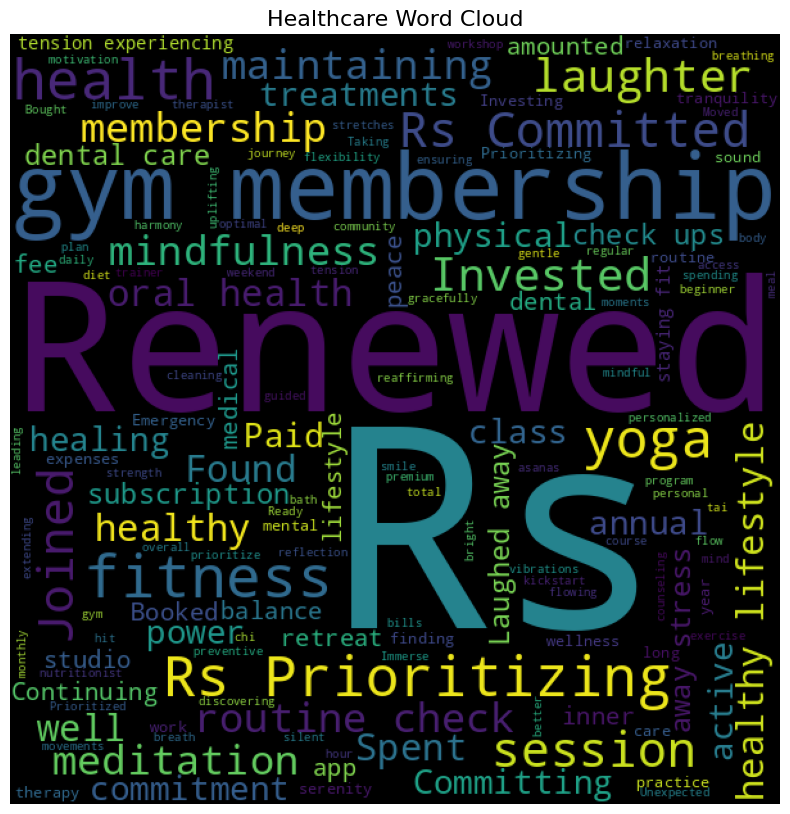

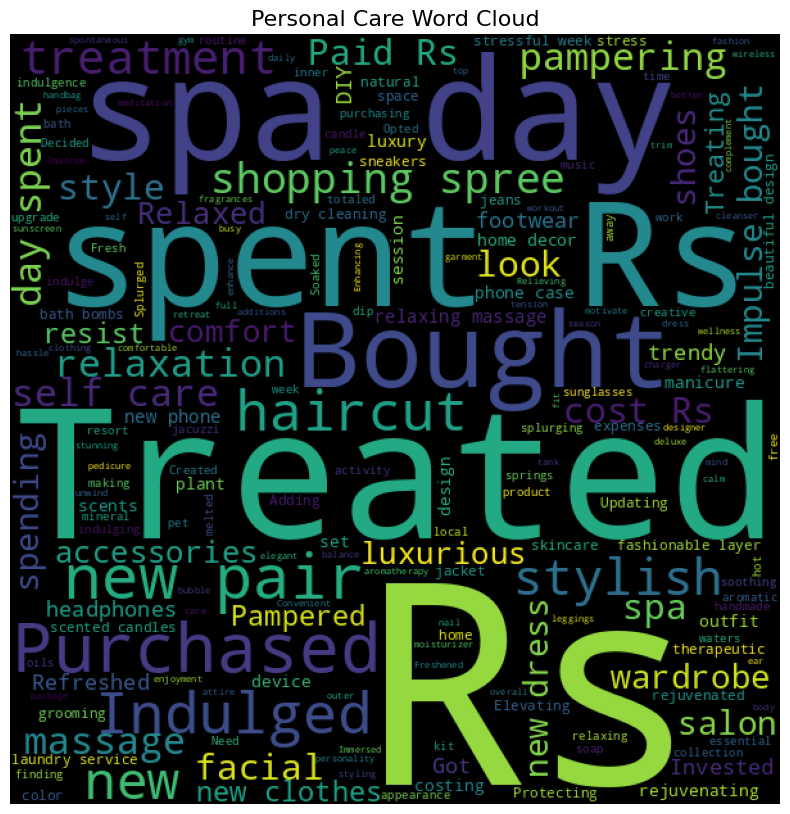

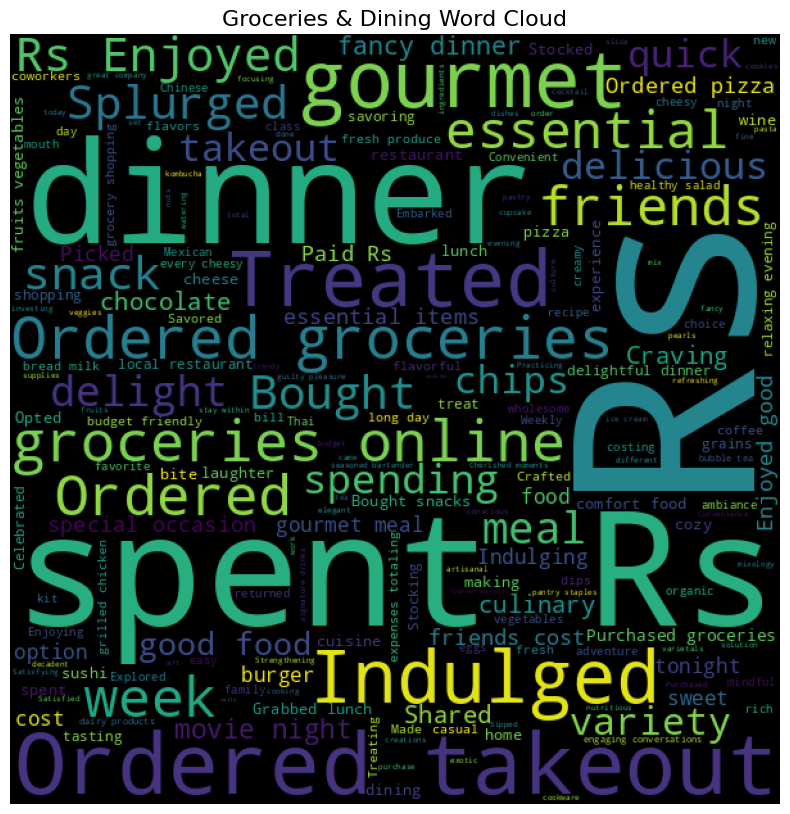

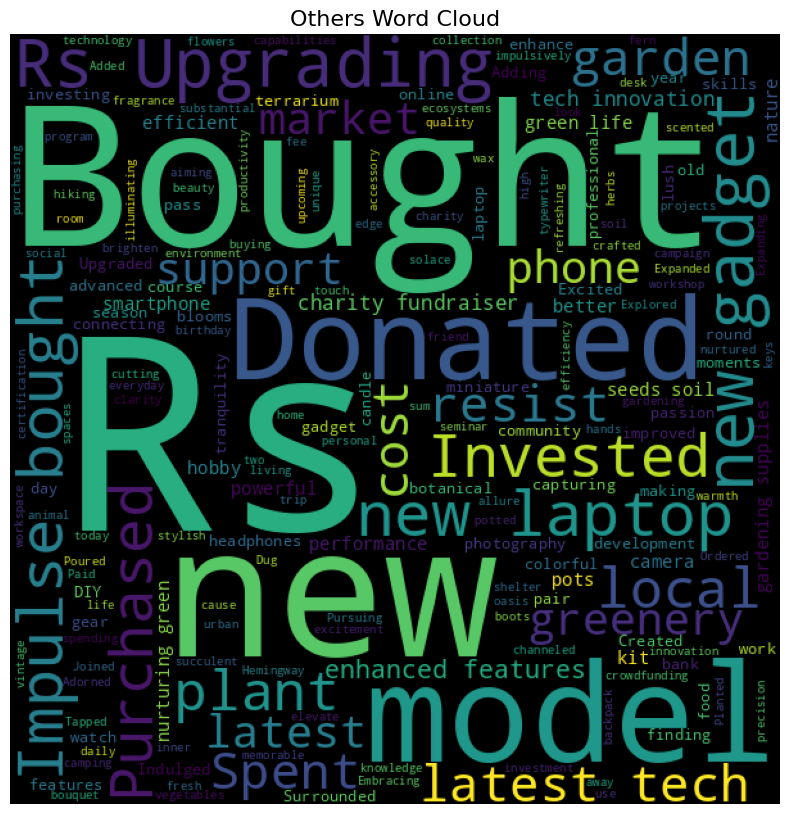

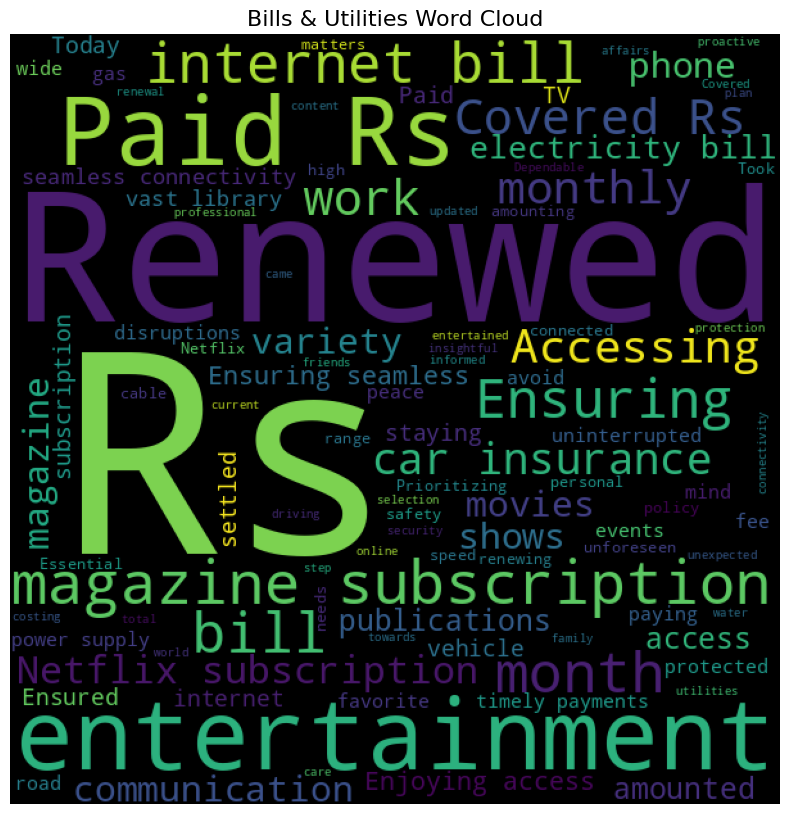

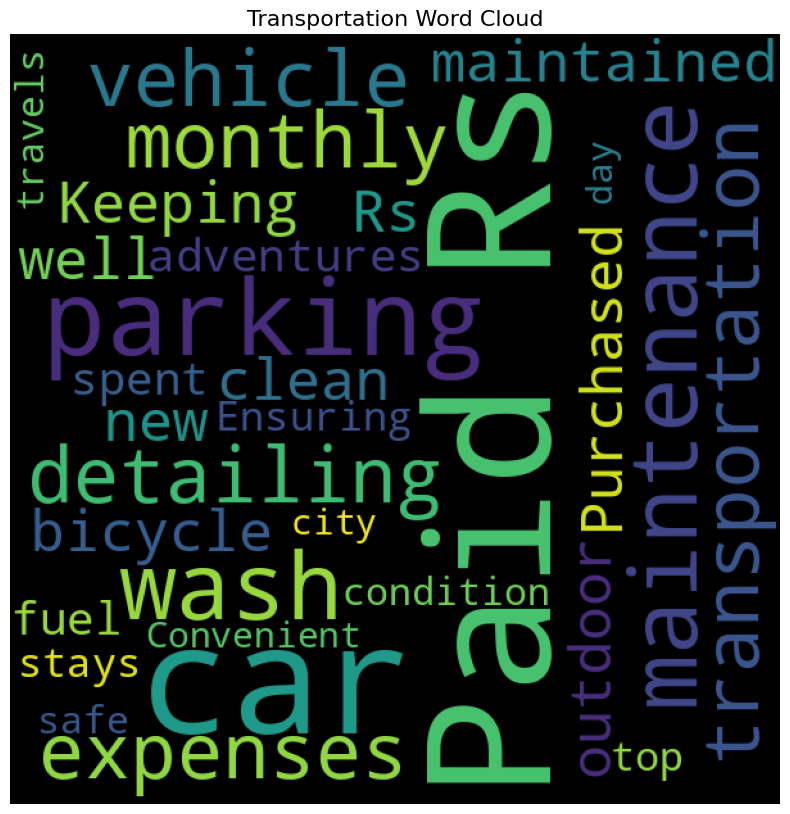

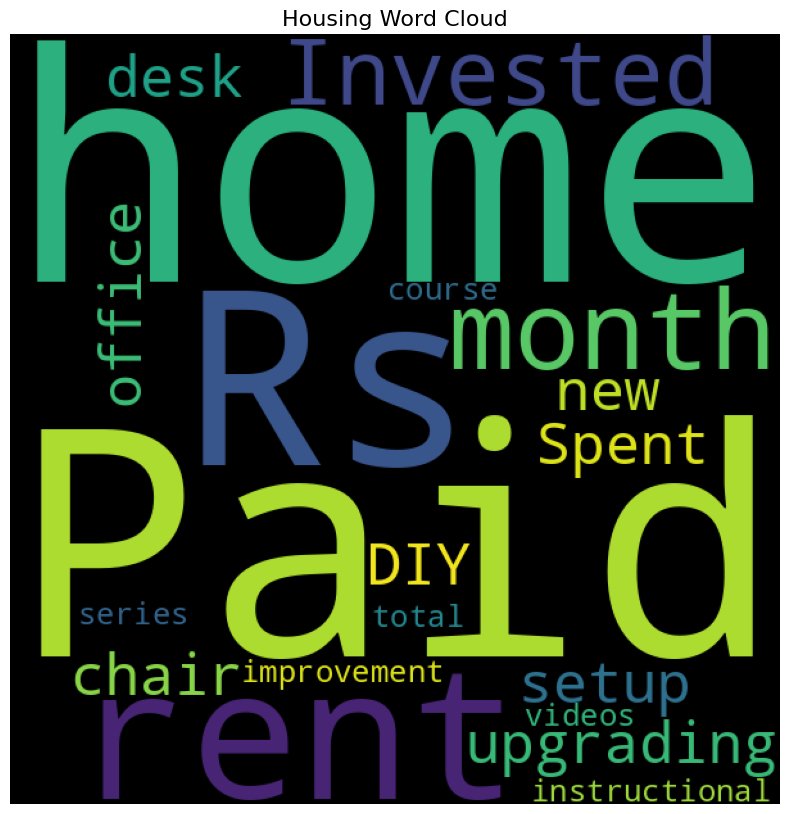

In [19]:
emotions_list = train_data['Categorical_Emotion'].unique()
for emotion in emotions_list:
    text = ' '.join([sentence for sentence in train_data.loc[train_data['Categorical_Emotion'] == emotion,'Comment']])
    wordcloud = WordCloud(width = 600, height = 600).generate(text)
    words_cloud(wordcloud, emotion)

In [20]:
lb = LabelEncoder()
train_data['Psy_Emotion'] = lb.fit_transform(train_data['Psy_Emotion'])
train_data['Categorical_Emotion'] = lb.fit_transform(train_data['Categorical_Emotion'])

In [21]:
df = train_data.copy()
df.tail()

Comment  Psy_Emotion  \
998   Invested in a new laptop for remote work. The ...            3   
999   Renewed my gym membership for Rs 2469. Committ...            6   
1000             Renewed my gym membership for Rs 1899.            6   
1001  Indulged in a fancy dinner for Rs 1979. Celebr...            1   
1002                          Ordered pizza for Rs 239.            6   

      Categorical_Emotion  length  
998                     6      84  
999                     4      76  
1000                    4      38  
1001                    3      91  
1002                    3      25

In [22]:
X_train, X_test, y_train_psy, y_test_psy, y_train_cat, y_test_cat = train_test_split(df['Comment'], df['Psy_Emotion'], df['Categorical_Emotion'], test_size = 0.2, random_state=42)

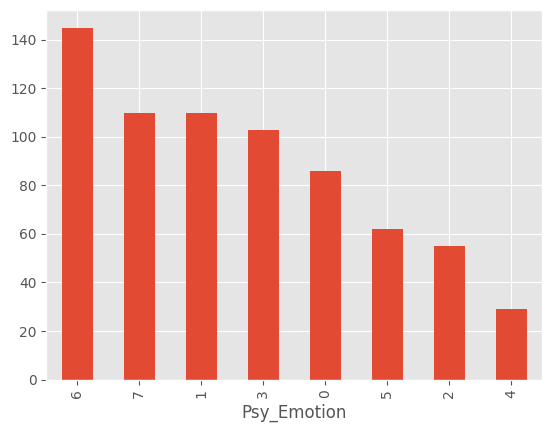

In [23]:
y_train_psy.value_counts().plot(kind = 'bar') # Plotting the bar plot for visualizing the countness of positive and negative labels
plt.show()

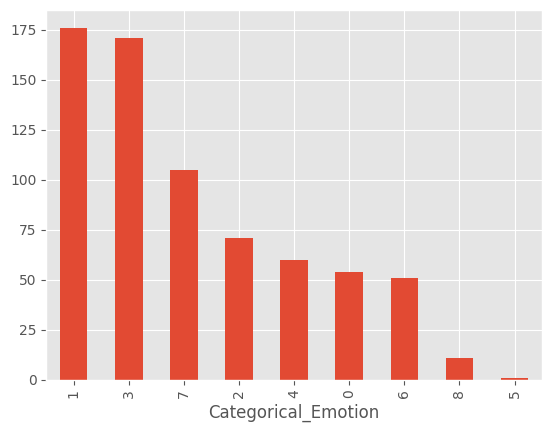

In [24]:
y_train_cat.value_counts().plot(kind = 'bar') # Plotting the bar plot for visualizing the countness of positive and negative labels
plt.show()

In [25]:
## Perfoming the text preprocessing

nltk.download('stopwords')  # Downloading all the stopwords from the nltk library
pattern = re.compile('<.*?>')  # Pattern for removing the HTML tags
punctuation = string.punctuation   # Extracting all punctuation from the string library
ps = PorterStemmer()  # Creating a PorterStemmer object for the stemming purpose
tokenizer = Tokenizer() # Creating a Tokenizer object for representing the text into numeric form

def text_preprocess(text):

  text = re.sub(pattern,'',text)  # Removing the HTML tags using re library

  text = text.lower()  # Lower case all the character present in the text

  text = text.translate(str.maketrans('','',punctuation))   # Removing all the punctuation from the text

  text = text.split()    # word tokenize the text

  text = [word.replace('rs', '') for word in text]

  text = [ps.stem(word) for word in text if word not in stopwords.words('english')]  # Removing the stopwords from the text and stem each word

  return ' '.join(text)  # Join each word for the formation of clear text in string form

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [26]:
processed_train_data = [text_preprocess(words) for words in X_train]   # Applying the text pre-processing fuction to the text column of train dataset
processed_test_data = [text_preprocess(words) for words in X_test]   # Applying the text pre-processing fuction to the text column of test dataset

In [27]:
# Putting all the processed text of train data into a whole text. Then fit this whole text into the tokenizer for word embedding.

whole_text = ''

for i in processed_train_data:
  whole_text = whole_text + i


tokenizer.fit_on_texts([whole_text])
print(len(tokenizer.word_index))   # Printing the vocab size or the number of words present in the train data text. This is used as hyperparameter for the embedding layer.

1672


In [28]:
y_train_psy

413    7
572    7
549    7
858    6
239    0
      ..
107    5
275    1
983    0
455    7
103    4
Name: Psy_Emotion, Length: 700, dtype: int64

In [29]:
# In this cell the train processed texts are converted into respective numeric sequences which are further padded to have equal sizes.

x_train_sequences = []

for i in processed_train_data:
  x_train_sequences.append(tokenizer.texts_to_sequences([i])[0])  # Each processed text is converted into sequences


x_train_padseq = pad_sequences(x_train_sequences,maxlen = 50, padding = 'post')  # Each sequences are padded to have equal size.

x_train = np.array(x_train_padseq)
y_train_psy = np.array(to_categorical(y_train_psy))
y_train_cat = np.array(to_categorical(y_train_cat))

In [30]:
# In this cell the test processed texts are converted into respective numeric sequences which are further padded to have equal sizes.

x_test_sequences = []

for i in processed_test_data:
  x_test_sequences.append(tokenizer.texts_to_sequences([i])[0])     # Each processed text is converted into sequences


x_test_padseq = pad_sequences(x_test_sequences,maxlen = 50, padding = 'post')    # Each sequences are padded to have equal size.

x_test = np.array(x_test_padseq)
y_test_psy = np.array(y_test_psy)
y_test_cat = np.array(y_test_cat)

In [31]:
y_test_psy.shape

(176,)

In [32]:
## Defining the hyperparameter of the embedding layer

vocab_size = 1672   # vocabulary size of the tokenizer
dim = 50             # Number of dense vector dimension required for the output
sent_length = 50    # The length of each sequence

In [33]:
# Bi-LSTM Model

input_layer_lstm = Input(shape=(sent_length,))
embedding_layer_lstm = Embedding(input_dim=vocab_size, output_dim=dim)(input_layer_lstm)
lstm_layer = Bidirectional(LSTM(128))(embedding_layer_lstm)
dropout_layer = Dropout(0.3)(lstm_layer)
normalized_layer = BatchNormalization()(dropout_layer)
psych_output = Dense(8, activation='softmax', name='psych_output')(lstm_layer)
cat_output = Dense(9, activation='softmax', name='cat_output')(lstm_layer)

In [34]:
# Create the model
bidirectional_lstm_model = Model(inputs=input_layer_lstm, outputs=[psych_output, cat_output])

bidirectional_lstm_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

bidirectional_lstm_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 50, 50)               83600     ['input_1[0][0]']             
                                                                                                  
 bidirectional (Bidirection  (None, 256)                  183296    ['embedding[0][0]']           
 al)                                                                                              
                                                                                                  
 psych_output (Dense)        (None, 8)                    2056      ['bidirectional[0][0]']   

In [35]:
checkpoint_filepath = 'best_model_bi_lstm.h5'

# Create the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',  # Monitor validation loss
    save_best_only=True,  # Save only the best model based on the monitored metric
    mode='min',  # Mode 'min' for validation loss, 'max' for validation accuracy
    verbose=1  # Print information about saving checkpoints
)

# Create the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,  # Print information about early stopping
    restore_best_weights=True  # Restore the best model weights based on validation loss
)

# Create the ReduceLROnPlateau callback
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.2,  # Factor by which the learning rate will be reduced
    patience=3,  # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,  # Minimum learning rate allowed
    verbose=1  # Print information about reducing learning rate
)

In [36]:
# Train the model
bidirectional_lstm_model_history = bidirectional_lstm_model.fit(x_train, {'psych_output': y_train_psy, 'cat_output': y_train_cat}, epochs=20, batch_size=16, validation_split=0.2, callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback])


Epoch 1/20
35/35 [==============================] - ETA: 0s - loss: 4.0205 - psych_output_loss: 2.0276 - cat_output_loss: 1.9929 - psych_output_accuracy: 0.2054 - cat_output_accuracy: 0.2554
Epoch 1: val_loss improved from inf to 3.89398, saving model to best_model_bi_lstm.h5
35/35 [==============================] - 10s 161ms/step - loss: 4.0205 - psych_output_loss: 2.0276 - cat_output_loss: 1.9929 - psych_output_accuracy: 0.2054 - cat_output_accuracy: 0.2554 - val_loss: 3.8940 - val_psych_output_loss: 2.0045 - val_cat_output_loss: 1.8895 - val_psych_output_accuracy: 0.2643 - val_cat_output_accuracy: 0.3500 - lr: 0.0010
Epoch 2/20
 1/35 [..............................] - ETA: 0s - loss: 3.8516 - psych_output_loss: 2.0198 - cat_output_loss: 1.8319 - psych_output_accuracy: 0.3750 - cat_output_accuracy: 0.3750

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


35/35 [==============================] - ETA: 0s - loss: 3.7260 - psych_output_loss: 1.9127 - cat_output_loss: 1.8134 - psych_output_accuracy: 0.2839 - cat_output_accuracy: 0.3732
Epoch 2: val_loss improved from 3.89398 to 3.55725, saving model to best_model_bi_lstm.h5
35/35 [==============================] - 3s 86ms/step - loss: 3.7260 - psych_output_loss: 1.9127 - cat_output_loss: 1.8134 - psych_output_accuracy: 0.2839 - cat_output_accuracy: 0.3732 - val_loss: 3.5573 - val_psych_output_loss: 1.8487 - val_cat_output_loss: 1.7085 - val_psych_output_accuracy: 0.3786 - val_cat_output_accuracy: 0.4286 - lr: 0.0010
Epoch 3/20
33/35 [===========================>..] - ETA: 0s - loss: 3.0637 - psych_output_loss: 1.6020 - cat_output_loss: 1.4617 - psych_output_accuracy: 0.4962 - cat_output_accuracy: 0.4640
Epoch 3: val_loss improved from 3.55725 to 2.77796, saving model to best_model_bi_lstm.h5
35/35 [==============================] - 1s 42ms/step - loss: 3.0408 - psych_output_loss: 1.5938 - c

In [37]:
# Bi-GRU Model

input_layer_gru = Input(shape=(sent_length,))
embedding_layer_gru = Embedding(input_dim=vocab_size, output_dim=dim)(input_layer_gru)
gru_layer = Bidirectional(GRU(128))(embedding_layer_gru)
dropout_layer = Dropout(0.3)(gru_layer)
normalized_layer = BatchNormalization()(dropout_layer)
psych_output = Dense(8, activation='softmax', name='psych_output')(gru_layer)
cat_output = Dense(9, activation='softmax', name='cat_output')(gru_layer)

In [38]:
# Create the model
bidirectional_gru_model = Model(inputs=input_layer_gru, outputs=[psych_output, cat_output])

bidirectional_gru_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

bidirectional_gru_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 50, 50)               83600     ['input_2[0][0]']             
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 256)                  138240    ['embedding_1[0][0]']         
 onal)                                                                                            
                                                                                                  
 psych_output (Dense)        (None, 8)                    2056      ['bidirectional_1[0][0]'

In [39]:
checkpoint_filepath = 'best_model_bi_gru.h5'

# Create the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',  # Monitor validation loss
    save_best_only=True,  # Save only the best model based on the monitored metric
    mode='min',  # Mode 'min' for validation loss, 'max' for validation accuracy
    verbose=1  # Print information about saving checkpoints
)

# Create the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,  # Print information about early stopping
    restore_best_weights=True  # Restore the best model weights based on validation loss
)

# Create the ReduceLROnPlateau callback
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.2,  # Factor by which the learning rate will be reduced
    patience=3,  # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,  # Minimum learning rate allowed
    verbose=1  # Print information about reducing learning rate
)

In [40]:
# Train the model
bidirectional_gru_model_history = bidirectional_gru_model.fit(x_train, {'psych_output': y_train_psy, 'cat_output': y_train_cat}, epochs=20, batch_size=16, validation_split=0.2, callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback])


Epoch 1/20
35/35 [==============================] - ETA: 0s - loss: 3.9641 - psych_output_loss: 1.9986 - cat_output_loss: 1.9655 - psych_output_accuracy: 0.2232 - cat_output_accuracy: 0.3125
Epoch 1: val_loss improved from inf to 3.79853, saving model to best_model_bi_gru.h5
35/35 [==============================] - 8s 127ms/step - loss: 3.9641 - psych_output_loss: 1.9986 - cat_output_loss: 1.9655 - psych_output_accuracy: 0.2232 - cat_output_accuracy: 0.3125 - val_loss: 3.7985 - val_psych_output_loss: 1.9597 - val_cat_output_loss: 1.8388 - val_psych_output_accuracy: 0.3357 - val_cat_output_accuracy: 0.4357 - lr: 0.0010
Epoch 2/20
 1/35 [..............................] - ETA: 3s - loss: 3.5140 - psych_output_loss: 1.9736 - cat_output_loss: 1.5404 - psych_output_accuracy: 0.1250 - cat_output_accuracy: 0.5625

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/35 [===========================>..] - ETA: 0s - loss: 3.3890 - psych_output_loss: 1.7503 - cat_output_loss: 1.6387 - psych_output_accuracy: 0.4564 - cat_output_accuracy: 0.4470
Epoch 2: val_loss improved from 3.79853 to 3.02318, saving model to best_model_bi_gru.h5
35/35 [==============================] - 2s 47ms/step - loss: 3.3540 - psych_output_loss: 1.7314 - cat_output_loss: 1.6226 - psych_output_accuracy: 0.4625 - cat_output_accuracy: 0.4554 - val_loss: 3.0232 - val_psych_output_loss: 1.5799 - val_cat_output_loss: 1.4433 - val_psych_output_accuracy: 0.4429 - val_cat_output_accuracy: 0.5429 - lr: 0.0010
Epoch 3/20
33/35 [===========================>..] - ETA: 0s - loss: 2.5240 - psych_output_loss: 1.3491 - cat_output_loss: 1.1748 - psych_output_accuracy: 0.5568 - cat_output_accuracy: 0.5947
Epoch 3: val_loss improved from 3.02318 to 2.53370, saving model to best_model_bi_gru.h5
35/35 [==============================] - 1s 28ms/step - loss: 2.4944 - psych_output_loss: 1.3286 - cat

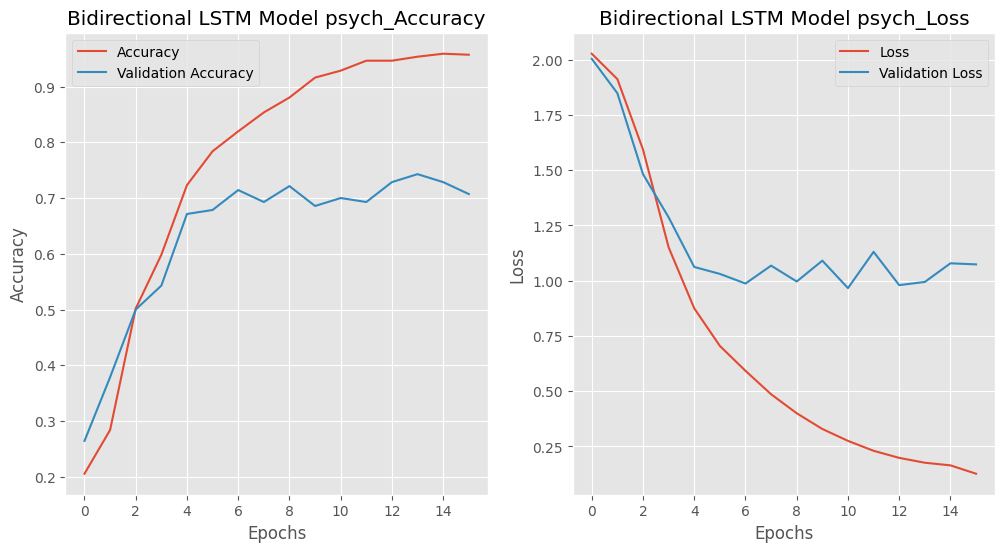

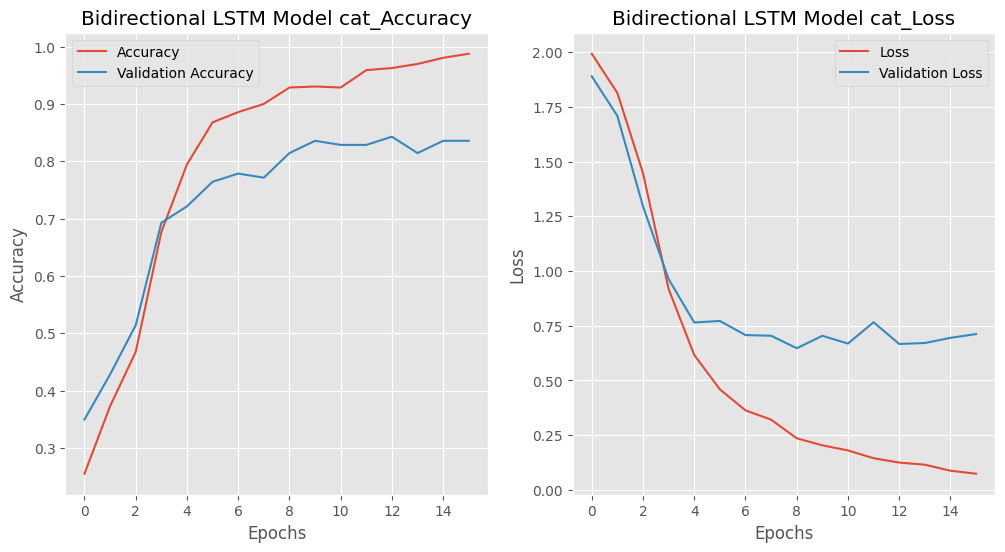

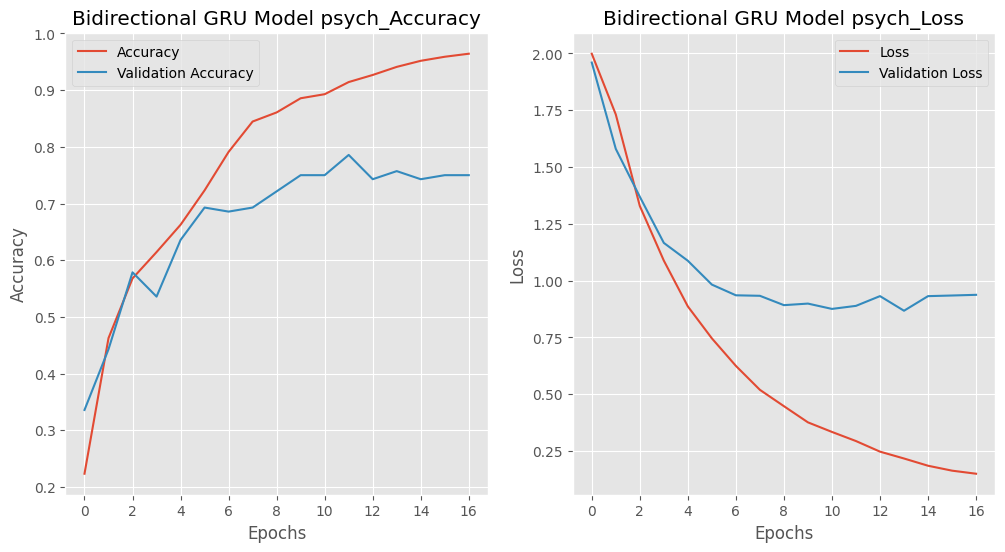

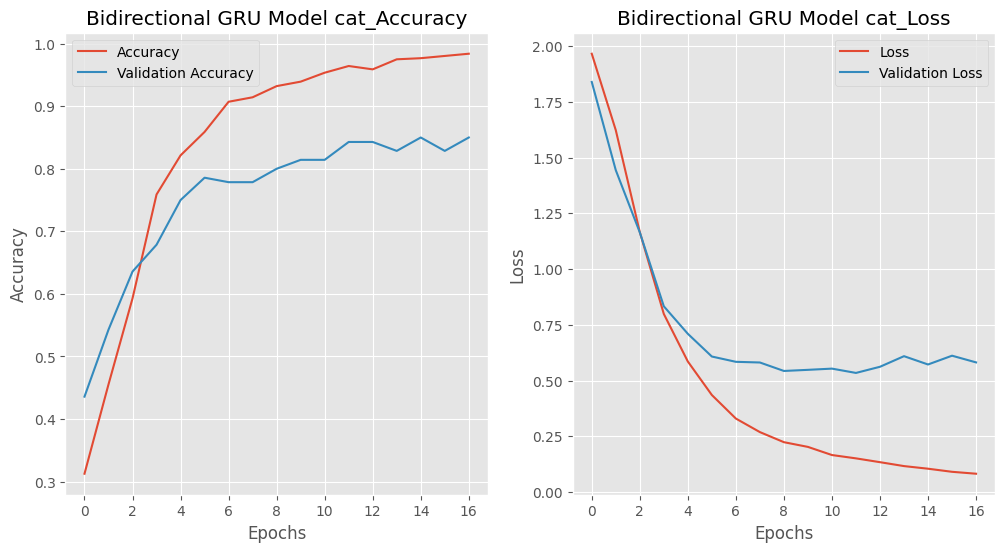

In [41]:
# Setting the figure size of the plot
plt.figure(figsize=(12,6))


# Plotting the psych_accuracy plot of Bidirectional LSTM model
plt.subplot(1,2,1)
plt.title("Bidirectional LSTM Model psych_Accuracy")
plt.plot(bidirectional_lstm_model_history.history['psych_output_accuracy'],label='Accuracy')
plt.plot(bidirectional_lstm_model_history.history['val_psych_output_accuracy'],label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()


# Plotting the psych_loss plot of Bidirectional LSTM model
plt.subplot(1,2,2)
plt.title("Bidirectional LSTM Model psych_Loss")
plt.plot(bidirectional_lstm_model_history.history['psych_output_loss'],label='Loss')
plt.plot(bidirectional_lstm_model_history.history['val_psych_output_loss'],label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


# Plotting the cat_accuracy plot of Bidirectional LSTM model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Bidirectional LSTM Model cat_Accuracy")
plt.plot(bidirectional_lstm_model_history.history['cat_output_accuracy'],label='Accuracy')
plt.plot(bidirectional_lstm_model_history.history['val_cat_output_accuracy'],label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()


# Plotting the cat_loss plot of Bidirectional LSTM model
plt.subplot(1,2,2)
plt.title("Bidirectional LSTM Model cat_Loss")
plt.plot(bidirectional_lstm_model_history.history['cat_output_loss'],label='Loss')
plt.plot(bidirectional_lstm_model_history.history['val_cat_output_loss'],label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plotting the psych_accuracy plot of Bidirectional GRU model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Bidirectional GRU Model psych_Accuracy")
plt.plot(bidirectional_gru_model_history.history['psych_output_accuracy'],label='Accuracy')
plt.plot(bidirectional_gru_model_history.history['val_psych_output_accuracy'],label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plotting the psych_loss plot of Bidirectional GRU model
plt.subplot(1,2,2)
plt.title("Bidirectional GRU Model psych_Loss")
plt.plot(bidirectional_gru_model_history.history['psych_output_loss'],label='Loss')
plt.plot(bidirectional_gru_model_history.history['val_psych_output_loss'],label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plotting the cat_accuracy plot of Bidirectional GRU model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Bidirectional GRU Model cat_Accuracy")
plt.plot(bidirectional_gru_model_history.history['cat_output_accuracy'],label='Accuracy')
plt.plot(bidirectional_gru_model_history.history['val_cat_output_accuracy'],label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plotting the cat_loss plot of Bidirectional GRU model
plt.subplot(1,2,2)
plt.title("Bidirectional GRU Model cat_Loss")
plt.plot(bidirectional_gru_model_history.history['cat_output_loss'],label='Loss')
plt.plot(bidirectional_gru_model_history.history['val_cat_output_loss'],label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [42]:
# Predicting the output of each model on test data for model evaluation
# ----------------------------------------------------------------------
y_pred_bilstm = bidirectional_lstm_model.predict(x_test)
y_pred_bigru = bidirectional_gru_model.predict(x_test)

y_pred_bilstm_psych = y_pred_bilstm[0]
y_pred_bilstm_cat = y_pred_bilstm[1]

y_pred_bigru_psych = y_pred_bigru[0]
y_pred_bigru_cat = y_pred_bigru[1]

6/6 [==============================] - 1s 5ms/step


In [43]:
# Converting the continuous output model into discrete classes
# ---------------------------------------------------------------------
y_pred_bilstm_psych = np.array([np.argmax(x) for x in y_pred_bilstm_psych])
y_pred_bilstm_cat = np.array([np.argmax(x) for x in y_pred_bilstm_cat])

y_pred_bigru_psych = np.array([np.argmax(x) for x in y_pred_bigru_psych])
y_pred_bigru_cat = np.array([np.argmax(x) for x in y_pred_bigru_cat])

In [44]:
# Predicting the accuracy_score,f1_score,recall_score,precision_score of each model
# Then converting all the details into dataframe


result = {"Model Name":['Bidirectional LSTM',"Bidirectional GRU"],
         "Psy Accuracy Score":[accuracy_score(y_test_psy,y_pred_bilstm_psych),accuracy_score(y_test_psy,y_pred_bigru_psych)],
         "Cat Accuracy Score":[accuracy_score(y_test_cat,y_pred_bilstm_cat),accuracy_score(y_test_cat,y_pred_bigru_cat)],
         "Psy F1 Score(macro)":[f1_score(y_test_psy,y_pred_bilstm_psych,average='macro'),f1_score(y_test_psy,y_pred_bigru_psych,average='macro')],
         "Cat F1 Score(macro)":[f1_score(y_test_cat,y_pred_bilstm_cat,average='macro'),f1_score(y_test_cat,y_pred_bigru_cat,average='macro')],
         "Psy Recall Score(macro)":[recall_score(y_test_psy,y_pred_bilstm_psych,average='macro'),recall_score(y_test_psy,y_pred_bigru_psych,average='macro')],
         "Cat Recall Score(macro)":[recall_score(y_test_cat,y_pred_bilstm_cat,average='macro'),recall_score(y_test_cat,y_pred_bigru_cat,average='macro')],
         "Psy Precision Score(macro)":[precision_score(y_test_psy,y_pred_bilstm_psych,average='macro'),precision_score(y_test_psy,y_pred_bigru_psych,average='macro')],
         "Cat Precision Score(macro)":[precision_score(y_test_cat,y_pred_bilstm_cat,average='macro'),precision_score(y_test_cat,y_pred_bigru_cat,average='macro')],
         "Psy F1 Score(micro)":[f1_score(y_test_psy,y_pred_bilstm_psych,average='micro'),f1_score(y_test_psy,y_pred_bigru_psych,average='micro')],
         "Cat F1 Score(micro)":[f1_score(y_test_cat,y_pred_bilstm_cat,average='micro'),f1_score(y_test_cat,y_pred_bigru_cat,average='micro')],
         "Psy Recall Score(micro)":[recall_score(y_test_psy,y_pred_bilstm_psych,average='micro'),recall_score(y_test_psy,y_pred_bigru_psych,average='micro')],
         "Cat Recall Score(micro)":[recall_score(y_test_cat,y_pred_bilstm_cat,average='micro'),recall_score(y_test_cat,y_pred_bigru_cat,average='micro')],
         "Psy Precision Score(micro)":[precision_score(y_test_psy,y_pred_bilstm_psych,average='micro'),precision_score(y_test_psy,y_pred_bigru_psych,average='micro')],
         "Cat Precision Score(micro)":[precision_score(y_test_cat,y_pred_bilstm_cat,average='micro'),precision_score(y_test_cat,y_pred_bigru_cat,average='micro')],}

result_df = pd.DataFrame(result)

result_df.to_excel("Report of Trained Model.xlsx")

display(result_df)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model Name  Psy Accuracy Score  Cat Accuracy Score  \
0  Bidirectional LSTM            0.761364            0.857955   
1   Bidirectional GRU            0.755682            0.863636   

   Psy F1 Score(macro)  Cat F1 Score(macro)  Psy Recall Score(macro)  \
0             0.719761             0.686847                 0.720376   
1             0.717401             0.733305                 0.719419   

   Cat Recall Score(macro)  Psy Precision Score(macro)  \
0                 0.682953                    0.727447   
1                 0.747531                    0.716916   

   Cat Precision Score(macro)  Psy F1 Score(micro)  Cat F1 Score(micro)  \
0                    0.746235             0.761364             0.857955   
1                    0.736180             0.755682             0.863636   

   Psy Recall Score(micro)  Cat Recall Score(micro)  \
0                 0.761364                 0.857955   
1                 0.755682                 0.863636   

   Psy Precision Score(micro)  Cat Precision Score(micro)  
0                    0.761364                    0.857955  
1                    0.755682                    0.863636

In [45]:
# Making a predictive function which takes the input as text and in output it provide the emotion of the text

def predict_emotion_of_text(text):

    processed_text = text_preprocess(text)
    text_to_sequence = tokenizer.texts_to_sequences([processed_text])[0]
    padded_sequence = pad_sequences([text_to_sequence],maxlen = 50, padding = 'post')

    prediction = bidirectional_lstm_model.predict(padded_sequence)    # We can use any model from  above like Bidirection LSTM, LSTM, Stack LSTM, GRU, Stack GRU Or Bidirectional GRU. As the accuracy of Bidirectional is more. So in this case I have Choose this model in predictive system.

    classes_psy = ['Aspiration Focused','Emotional Comfort','Essential Need','Experiential Investment','Impulse Buy','Mindful Spending','Routine Expense','Social Outlay']
    classes_cat = ['Bills & Utilities','Entertainment','Financial Services','Groceries & Dining','Healthcare','Housing','Others','Personal Care','Transportation']

    print("Input: ",text)
    print("Output: ",classes_psy[np.argmax(prediction[0])])
    print("Output: ",classes_cat[np.argmax(prediction[1])])
    print("\n")

In [47]:
predict_emotion_of_text("Today, I settled the monthly electricity bill. It amounted to Rs 5821. Ensuring timely payments to avoid any disruptions in power supply")
predict_emotion_of_text("Bought a new pair of shoes for Rs 4000.")


1/1 [==============================] - 0s 21ms/step
Input:  Today, I settled the monthly electricity bill. It amounted to Rs 5821. Ensuring timely payments to avoid any disruptions in power supply
Output:  Essential Need
Output:  Bills & Utilities


1/1 [==============================] - 0s 20ms/step
Input:  Bought a new pair of shoes for Rs 4000.
Output:  Mindful Spending
Output:  Personal Care


